## Modelo de clasificación de Imágenes


DIEGO ALEJANDRO ROBLEDO MEJÍA

Para el siguiente código, se usa el siguiente DataSet:

 [Enlace](https://data.mendeley.com/datasets/6ps7gtp2wg/1)

In [ ]:
# De manera inicial cargamos nuestro archivo e importamos las librerías que usaremos

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import glob
import cv2

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
# descomprimimos el dataset en una carpeta nombrada data

with zipfile.ZipFile('6ps7gtp2wg-1.zip', 'r') as zip_ref:
    zip_ref.extractall('/data')

In [ ]:
#Hiperparametros

input_size = 112*112
num_epochs = 2
batch_size = 100
learning_rate = 0.001

target = ["F_Banana", "F_Lemon", "F_Lulo", "F_Mango", "F_Orange", "F_Strawberry", "F_Tamarillo", "F_Tomato",
          "S_Banana", "S_Lemon", "S_Lulo", "S_Mango", "S_Orange", "S_Strawberry", "S_Tamarillo", "S_Tomato"]

In [ ]:
# Creamos una clase nueva para cargar nuestros datos

class CustomDataset(Dataset):
  pass

  # Constructor - se envía la ruta y realiza un data con las imágenes y clasificación
  def __init__(self, path):
    self.imgs_path = path
    file_list = glob.glob(self.imgs_path + "*")
    self.data = []

    for class_path in file_list:
      class_name = class_path.split("/")[-1]

      for img_path in glob.glob(class_path + "/*.jpg"):
        self.data.append([img_path, class_name])

      self.class_map = {"F_Banana" : 0, "F_Lemon": 1, "F_Lulo": 2, "F_Mango": 3, "F_Orange": 4, "F_Strawberry": 5, "F_Tamarillo": 6, "F_Tomato": 7,
                        "S_Banana": 8, "S_Lemon": 9, "S_Lulo": 10, "S_Mango": 11, "S_Orange": 12, "S_Strawberry": 13, "S_Tamarillo": 14, "S_Tomato": 15}
      self.img_dim = (112, 112)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    img_path, class_name = self.data[idx]
    img = cv2.imread(img_path)
    img = cv2.resize(img, self.img_dim)
    class_id = self.class_map[class_name]
    img_tensor = torch.from_numpy(img)
    img_tensor = img_tensor.permute(2, 0, 1)
    class_id = torch.tensor(class_id)
    return img_tensor.float(), class_id.float()

In [ ]:
# Creamos nuestro dataset con la ruta, y guardamos las variables X y Y

dataset = CustomDataset("/.data/FRUIT-16K/")

X = []
y = []

for i in range(len(dataset.data)):
  obt_1, obt_2 = dataset.__getitem__(i)
  X.append(obt_1)
  y.append(obt_2)

In [ ]:
# Partimos el data set usando el 20% para pruebas, y se ejecutan los DataLoader

def merge(list1, list2):
  merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))]
  return merged_list

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2)
#y_train = torch.tensor(y_train, dtype=torch.float, device=device)
#y_test = torch.tensor(y_test, dtype=torch.float, device=device)

dataset_train = merge(X_train,y_train)
dataset_test = merge(X_test,y_test)

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [ ]:
examples = iter(train_loader)
examples_test = iter(test_loader)

samples, labels = next(examples)
samples_test, labels_test = next(examples_test)

print(samples.shape, labels.shape)
print(samples_test.shape, labels_test.shape)

torch.Size([100, 3, 112, 112]) torch.Size([100])
torch.Size([100, 3, 112, 112]) torch.Size([100])


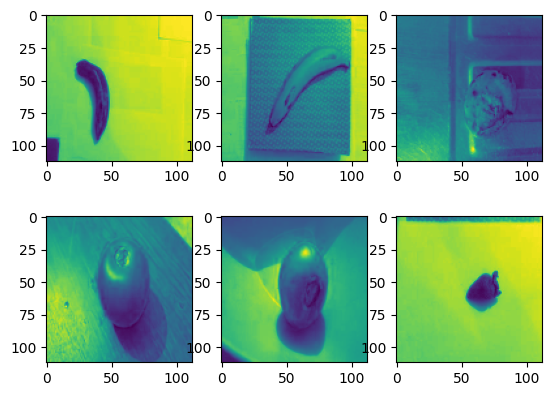

In [ ]:
# imprimimos algunas imagenes para mirar si quedó aleatorio la separación

for i in range(6):
  plt.subplot(2,3, i+1)
  plt.imshow(samples[i][0])
plt.show()

In [ ]:
# Creamos las clases para nuestras convoluciones y posterior redes neuronales
# se crean 3 clases para responder a las preguntas del taller: ¿Qué impacto tiene la utilización de 1, 2, y 3 capas convolucionales ocultas en la exactitud de tu modelo?
#pixeles: 28x28

class ConvNet_1(torch.nn.Module):
  def __init__(self):
    super(ConvNet_1, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(6*54*54,1000)
    self.fc2 = nn.Linear(1000, 500)
    self.fc3 = nn.Linear(500, 16)
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = x.view(-1, 6*54*54)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

class ConvNet_2(torch.nn.Module):
  def __init__(self):
    super(ConvNet_2, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16*25*25,1000)
    self.fc2 = nn.Linear(1000, 500)
    self.fc3 = nn.Linear(500, 16)
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16*25*25)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

class ConvNet_3(torch.nn.Module):
  def __init__(self):
    super(ConvNet_3, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6, 12, 5)
    self.conv3 = nn.Conv2d(12, 20, 5)
    self.fc1 = nn.Linear(20*10*10,1000)
    self.fc2 = nn.Linear(1000, 500)
    self.fc3 = nn.Linear(500, 16)
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = x.view(-1, 20*10*10)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

Primero vamos a responder a la segunda pregunta, y con los mejores resultados, y luego de determinar lo que le pasa al modelo según el número de capas de convolución, responderemos el punto 1, jugando con el número de épocas e iteraciones

In [ ]:
# Creamos el primer modelo, con 1 capa de convolución

model1 = ConvNet_1().to(device)
criterio = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model1.parameters(),lr = learning_rate, momentum = 0.9)
n_total_steps = len(train_loader)

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model1(images)
    loss = criterio(outputs, labels.long())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 50 == 0:
      print(f'Epoch [{epoch+1} / {num_epochs}], Step [{i+1} / {n_total_steps}], Loss: {loss.item():.4f}')
print('Entrenamiento Finalizo')

Epoch [1 / 2], Step [50 / 128], Loss: 2.7828
Epoch [1 / 2], Step [100 / 128], Loss: 2.7745
Epoch [2 / 2], Step [50 / 128], Loss: 2.7678
Epoch [2 / 2], Step [100 / 128], Loss: 2.7699
Entrenamiento Finalizo


En la anterior ejecución, podemos observar que la funicón de pérdida no tiene variaciones significativas

In [ ]:
# Medimos la exactitud del modelo, en cada una de las categorías

with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(len(target))]
  n_class_samples = [0 for i in range(len(target))]

  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model1(images)

    _, predicted = torch.max(outputs,1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()

    for i in range(batch_size):
      label = labels[i]
      pred = predicted[i]

      if (label == pred):
        n_class_correct[label.to(torch.long)] += 1
      n_class_samples[label.to(torch.long)] += 1
      #print(n_class_correct[label.to(torch.long)])
  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network: {acc} %')

  for i in range(10):
    acc = 100.0 * n_class_correct[i]/n_class_samples[i]
    print(f'Accuracy of {target[i]}: {acc} %')

Accuracy of the network: 4.65625 %
Accuracy of F_Banana: 2.9702970297029703 %
Accuracy of F_Lemon: 0.0 %
Accuracy of F_Lulo: 0.0 %
Accuracy of F_Mango: 0.0 %
Accuracy of F_Orange: 0.0 %
Accuracy of F_Strawberry: 0.0 %
Accuracy of F_Tamarillo: 0.0 %
Accuracy of F_Tomato: 0.0 %
Accuracy of S_Banana: 0.0 %
Accuracy of S_Lemon: 0.0 %


Anidado al comentario anterior, observamos una exactitud pobre, donde el modelo no pudo clasificar correctamente  las categorías, por lo que se deduce que utilizar una única capa no es adecuado para éste modelo de imágenes

In [ ]:
# Creamos el segundo modelo, con 2 capas de convolución

model2 = ConvNet_2().to(device)
criterio = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(),lr = learning_rate, momentum = 0.9)
n_total_steps = len(train_loader)

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model2(images)
    loss = criterio(outputs, labels.long())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 50 == 0:
      print(f'Epoch [{epoch+1} / {num_epochs}], Step [{i+1} / {n_total_steps}], Loss: {loss.item():.4f}')
print('Entrenamiento Finalizo')

Epoch [1 / 2], Step [50 / 128], Loss: 2.7666
Epoch [1 / 2], Step [100 / 128], Loss: 2.7718
Epoch [2 / 2], Step [50 / 128], Loss: 2.7463
Epoch [2 / 2], Step [100 / 128], Loss: 2.6919
Entrenamiento Finalizo


Observamos que el modelo mejoró en relación a la ejecución de 1 sola capa, sin embargo la función de pérdida sigue estando muy alejada de cero, lo que significa que no pudo encontrar un mínimo local adecuado

In [ ]:
# Medimos la exactitud del modelo, en cada una de las categorías

with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(len(target))]
  n_class_samples = [0 for i in range(len(target))]

  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model2(images)

    _, predicted = torch.max(outputs,1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()

    for i in range(batch_size):
      label = labels[i]
      pred = predicted[i]

      if (label == pred):
        n_class_correct[label.to(torch.long)] += 1
      n_class_samples[label.to(torch.long)] += 1
      #print(n_class_correct[label.to(torch.long)])
  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network: {acc} %')

  for i in range(10):
    acc = 100.0 * n_class_correct[i]/n_class_samples[i]
    print(f'Accuracy of {target[i]}: {acc} %')

Accuracy of the network: 14.6875 %
Accuracy of F_Banana: 0.49504950495049505 %
Accuracy of F_Lemon: 82.90155440414507 %
Accuracy of F_Lulo: 88.57142857142857 %
Accuracy of F_Mango: 0.975609756097561 %
Accuracy of F_Orange: 0.0 %
Accuracy of F_Strawberry: 5.649717514124294 %
Accuracy of F_Tamarillo: 0.4716981132075472 %
Accuracy of F_Tomato: 30.434782608695652 %
Accuracy of S_Banana: 1.0204081632653061 %
Accuracy of S_Lemon: 1.4705882352941178 %


Observamos quee efectivamente el modelo mejoró en relación a la utilziación de 1 sola capa de convolución, pero tal como se dijo en la celda anterior, el modelo sigue distante de encontrar una solución óptima, pues se observa que logró una exactitud de menos del 20%

In [ ]:
# Creamos el tercer modelo, con 3 capas de convolución

model3 = ConvNet_3().to(device)
criterio = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model3.parameters(),lr = learning_rate, momentum = 0.9)
n_total_steps = len(train_loader)

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model3(images)
    loss = criterio(outputs, labels.long())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 50 == 0:
      print(f'Epoch [{epoch+1} / {num_epochs}], Step [{i+1} / {n_total_steps}], Loss: {loss.item():.4f}')
print('Entrenamiento Finalizo')

Epoch [1 / 2], Step [50 / 128], Loss: 1.8368
Epoch [1 / 2], Step [100 / 128], Loss: 1.7894
Epoch [2 / 2], Step [50 / 128], Loss: 1.2659
Epoch [2 / 2], Step [100 / 128], Loss: 0.7721
Entrenamiento Finalizo


Logramos evidenciar que el uso de 3 capas de convolución, tiene un impacto significativo en la función de pérdida del modelo

In [ ]:
# Medimos la exactitud del modelo, en cada una de las categorías

with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(len(target))]
  n_class_samples = [0 for i in range(len(target))]

  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model3(images)

    _, predicted = torch.max(outputs,1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()

    for i in range(batch_size):
      label = labels[i]
      pred = predicted[i]

      if (label == pred):
        n_class_correct[label.to(torch.long)] += 1
      n_class_samples[label.to(torch.long)] += 1
      #print(n_class_correct[label.to(torch.long)])
  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network: {acc} %')

  for i in range(10):
    acc = 100.0 * n_class_correct[i]/n_class_samples[i]
    print(f'Accuracy of {target[i]}: {acc} %')

Accuracy of the network: 70.46875 %
Accuracy of F_Banana: 84.15841584158416 %
Accuracy of F_Lemon: 84.97409326424871 %
Accuracy of F_Lulo: 95.71428571428571 %
Accuracy of F_Mango: 42.926829268292686 %
Accuracy of F_Orange: 87.86407766990291 %
Accuracy of F_Strawberry: 18.07909604519774 %
Accuracy of F_Tamarillo: 89.15094339622641 %
Accuracy of F_Tomato: 79.71014492753623 %
Accuracy of S_Banana: 73.46938775510205 %
Accuracy of S_Lemon: 82.84313725490196 %


Con las líneas anteriores, observamos que al tener 1 sola capa de convolución, la exactitud del modelo es muy baja, y va mejorando conforme se aumentan las capas de convolución, así es cómo con dos capas de convoluciones, se aumenta la exactitud un poco y con 3 capas de convoluciones, el modelo aumenta su exactitud significativamente en relación al uso de una sola, respondiendo a la segundo pregunta del taller, pues se evidencia que la exactitud aumenta considerablemente aumentando las capas de convolución

Con lo anterior, seleccionando el modelo 3 (mejor resultado hasta el momento) se comenzará a responder la primer pregunta: ¿Qué impacto tiene el número de epochs y tamaño del lote en la exactitud de tu modelo?

In [ ]:
#Hiperparametros primero se cambia el batch_size

input_size = 112*112
num_epochs = 2
batch_size = 50
learning_rate = 0.001

se cambia el batch_size a sólo 50 para evaluar el comportamiento del modelo

In [ ]:
# Cargamos nuevamente el DataLoader, usando un batch_size inferior, luego se entrena nuevamente el modelo
# y por último se sacan las métricas

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

# Creamos el cuarto modelo, usando el modelo 3 y disminuyendo el batch_size

model4 = ConvNet_3().to(device)
criterio = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model4.parameters(),lr = learning_rate, momentum = 0.9)
n_total_steps = len(train_loader)

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model4(images)
    loss = criterio(outputs, labels.long())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 50 == 0:
      print(f'Epoch [{epoch+1} / {num_epochs}], Step [{i+1} / {n_total_steps}], Loss: {loss.item():.4f}')
print('Entrenamiento Finalizo')

# Medimos la exactitud del modelo, en cada una de las categorías

with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(len(target))]
  n_class_samples = [0 for i in range(len(target))]

  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model4(images)

    _, predicted = torch.max(outputs,1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()

    for i in range(batch_size):
      label = labels[i]
      pred = predicted[i]

      if (label == pred):
        n_class_correct[label.to(torch.long)] += 1
      n_class_samples[label.to(torch.long)] += 1
      #print(n_class_correct[label.to(torch.long)])
  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network: {acc} %')

  for i in range(10):
    acc = 100.0 * n_class_correct[i]/n_class_samples[i]
    print(f'Accuracy of {target[i]}: {acc} %')

Epoch [1 / 2], Step [50 / 256], Loss: 2.6347
Epoch [1 / 2], Step [100 / 256], Loss: 2.3562
Epoch [1 / 2], Step [150 / 256], Loss: 2.3358
Epoch [1 / 2], Step [200 / 256], Loss: 1.9801
Epoch [1 / 2], Step [250 / 256], Loss: 1.7377
Epoch [2 / 2], Step [50 / 256], Loss: 1.5085
Epoch [2 / 2], Step [100 / 256], Loss: 1.5004
Epoch [2 / 2], Step [150 / 256], Loss: 1.1864
Epoch [2 / 2], Step [200 / 256], Loss: 1.3558
Epoch [2 / 2], Step [250 / 256], Loss: 1.4508
Entrenamiento Finalizo
Accuracy of the network: 59.8125 %
Accuracy of F_Banana: 75.74257425742574 %
Accuracy of F_Lemon: 95.85492227979275 %
Accuracy of F_Lulo: 91.42857142857143 %
Accuracy of F_Mango: 34.146341463414636 %
Accuracy of F_Orange: 53.883495145631066 %
Accuracy of F_Strawberry: 61.5819209039548 %
Accuracy of F_Tamarillo: 49.056603773584904 %
Accuracy of F_Tomato: 59.42028985507246 %
Accuracy of S_Banana: 53.06122448979592 %
Accuracy of S_Lemon: 62.745098039215684 %


con el anterior código, observamos que al disminuir el número de batch_size, se aumentan las iteraciones, lo que permitiría al código, tener más "tiempo" para buscar el menor loss, sin embargo, por la manera cómo funciona el decenso del gradiente, también observamos que se tuvo un resultado muy bajo en algunas épocas, lo que pudo representar una mejor exactitud. Sin embargo, al seguir iterando, se desmejoró el resultado, obteniendo una exactitud más baja que el punto de referencia (modelo 3). se realizará una última prueba con un batch_size menor para evaluar

In [ ]:
#Hiperparametros primero se cambia el batch_size

input_size = 112*112  #224x224 pero se reduce a la mitad
num_epochs = 2
batch_size = 30
learning_rate = 0.001

# Cargamos nuevamente el DataLoader, usando un batch_size inferior, luego se entrena nuevamente el modelo
# y por último se sacan las métricas

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

# Creamos el quinto modelo, usando el modelo 3 y disminuyendo el batch_size

model5 = ConvNet_3().to(device)
criterio = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model5.parameters(),lr = learning_rate, momentum = 0.9)
n_total_steps = len(train_loader)

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model5(images)
    loss = criterio(outputs, labels.long())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 50 == 0:
      print(f'Epoch [{epoch+1} / {num_epochs}], Step [{i+1} / {n_total_steps}], Loss: {loss.item():.4f}')
print('Entrenamiento Finalizo')

Epoch [1 / 2], Step [50 / 427], Loss: 2.7234
Epoch [1 / 2], Step [100 / 427], Loss: 2.4293
Epoch [1 / 2], Step [150 / 427], Loss: 2.2208
Epoch [1 / 2], Step [200 / 427], Loss: 2.1591
Epoch [1 / 2], Step [250 / 427], Loss: 2.1207
Epoch [1 / 2], Step [300 / 427], Loss: 2.1125
Epoch [1 / 2], Step [350 / 427], Loss: 1.8611
Epoch [1 / 2], Step [400 / 427], Loss: 1.4494
Epoch [2 / 2], Step [50 / 427], Loss: 1.7863
Epoch [2 / 2], Step [100 / 427], Loss: 1.5200
Epoch [2 / 2], Step [150 / 427], Loss: 1.3981
Epoch [2 / 2], Step [200 / 427], Loss: 0.9741
Epoch [2 / 2], Step [250 / 427], Loss: 1.2739
Epoch [2 / 2], Step [300 / 427], Loss: 1.1959
Epoch [2 / 2], Step [350 / 427], Loss: 0.8481
Epoch [2 / 2], Step [400 / 427], Loss: 0.8132
Entrenamiento Finalizo


In [ ]:
# Medimos la exactitud del modelo, en cada una de las categorías

with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(len(target))]
  n_class_samples = [0 for i in range(len(target))]

  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model5(images)

    _, predicted = torch.max(outputs,1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()

    for i in range(len(images)):
      label = labels[i]
      pred = predicted[i]

      if (label == pred):
        n_class_correct[label.to(torch.long)] += 1
      n_class_samples[label.to(torch.long)] += 1
      #print(n_class_correct[label.to(torch.long)])
  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network: {acc} %')

  for i in range(10):
    acc = 100.0 * n_class_correct[i]/n_class_samples[i]
    print(f'Accuracy of {target[i]}: {acc} %')

Accuracy of the network: 60.28125 %
Accuracy of F_Banana: 92.07920792079207 %
Accuracy of F_Lemon: 76.6839378238342 %
Accuracy of F_Lulo: 86.19047619047619 %
Accuracy of F_Mango: 35.609756097560975 %
Accuracy of F_Orange: 47.0873786407767 %
Accuracy of F_Strawberry: 49.717514124293785 %
Accuracy of F_Tamarillo: 89.15094339622641 %
Accuracy of F_Tomato: 39.61352657004831 %
Accuracy of S_Banana: 75.0 %
Accuracy of S_Lemon: 72.54901960784314 %


Observamos el mismo comportamiento anterior, donde se logró un excelente punto mínimo en algunas iteraciones, pero el algoritmo continuó iterando, lo que aumentó el error. La conclusión es que es necesario agregar una función de regularizacion que permita un Early Stop al modelo y quedar con el mejor resultado.

La conclusión es que al modificar el batch_size, se modifica el número de iteraciones, pero no significa que mejore o empeore el resultado, pues dependerá de la función de pérdida y el decenso del gradiente y de otros hiperparámetros combinados

Por último, vamos a modificar el número de Épocas para mirar el comportamiento del modelo

In [ ]:
# Cargamos nuevamente el DataLoader, usando un batch_size inferior, luego se entrena nuevamente el modelo
# y por último se sacan las métricas

input_size = 112*112  #224x224 pero se reduce a la mitad
batch_size = 30
learning_rate = 0.001

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [ ]:
# Cambiamos el número de épocas

num_epochs = 4

# Creamos el sexto modelo, usando el modelo 3 y disminuyendo el batch_size

model6 = ConvNet_3().to(device)
criterio = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model6.parameters(),lr = learning_rate, momentum = 0.9)
n_total_steps = len(train_loader)

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model6(images)
    loss = criterio(outputs, labels.long())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 50 == 0:
      print(f'Epoch [{epoch+1} / {num_epochs}], Step [{i+1} / {n_total_steps}], Loss: {loss.item():.4f}')
print('Entrenamiento Finalizo')

Epoch [1 / 4], Step [50 / 427], Loss: 2.7630
Epoch [1 / 4], Step [100 / 427], Loss: 2.4944
Epoch [1 / 4], Step [150 / 427], Loss: 2.5086
Epoch [1 / 4], Step [200 / 427], Loss: 2.4668
Epoch [1 / 4], Step [250 / 427], Loss: 2.0272
Epoch [1 / 4], Step [300 / 427], Loss: 1.6887
Epoch [1 / 4], Step [350 / 427], Loss: 1.7059
Epoch [1 / 4], Step [400 / 427], Loss: 1.5271
Epoch [2 / 4], Step [50 / 427], Loss: 1.2979
Epoch [2 / 4], Step [100 / 427], Loss: 1.2810
Epoch [2 / 4], Step [150 / 427], Loss: 1.0488
Epoch [2 / 4], Step [200 / 427], Loss: 1.5505
Epoch [2 / 4], Step [250 / 427], Loss: 1.1636
Epoch [2 / 4], Step [300 / 427], Loss: 1.0063
Epoch [2 / 4], Step [350 / 427], Loss: 0.9130
Epoch [2 / 4], Step [400 / 427], Loss: 0.8246
Epoch [3 / 4], Step [50 / 427], Loss: 0.5389
Epoch [3 / 4], Step [100 / 427], Loss: 0.6203
Epoch [3 / 4], Step [150 / 427], Loss: 1.2140
Epoch [3 / 4], Step [200 / 427], Loss: 0.5845
Epoch [3 / 4], Step [250 / 427], Loss: 0.4753
Epoch [3 / 4], Step [300 / 427], Loss

In [ ]:
# Medimos la exactitud del modelo, en cada una de las categorías

with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(len(target))]
  n_class_samples = [0 for i in range(len(target))]

  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model6(images)

    _, predicted = torch.max(outputs,1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()

    for i in range(len(images)):
      label = labels[i]
      pred = predicted[i]

      if (label == pred):
        n_class_correct[label.to(torch.long)] += 1
      n_class_samples[label.to(torch.long)] += 1
      #print(n_class_correct[label.to(torch.long)])
  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network: {acc} %')

  for i in range(10):
    acc = 100.0 * n_class_correct[i]/n_class_samples[i]
    print(f'Accuracy of {target[i]}: {acc} %')

Accuracy of the network: 80.65625 %
Accuracy of F_Banana: 72.77227722772277 %
Accuracy of F_Lemon: 88.60103626943005 %
Accuracy of F_Lulo: 89.52380952380952 %
Accuracy of F_Mango: 69.26829268292683 %
Accuracy of F_Orange: 83.98058252427184 %
Accuracy of F_Strawberry: 72.31638418079096 %
Accuracy of F_Tamarillo: 87.26415094339623 %
Accuracy of F_Tomato: 80.67632850241546 %
Accuracy of S_Banana: 89.79591836734694 %
Accuracy of S_Lemon: 86.27450980392157 %


Con el doble de épocas, el modelo tiene mucho más tiempo de mejorar la función de pérdida, hasta lograr una exactitud mejor, sin embargo, también se observa el mismo comportamiento anterior, donde el modelo detectó funciones de pérdida mejores, previo a culminar las iteraciones, lo que representaría un mejor modelo

La conclusión es que aumentar el número de épocas mejora el modelo, pero existe la necesidad de implementar regularización, para mejorar incluso más los resultados.


Además, se evidencia que un sólo hiperparametro incide en el modelo, pero es la combinación de todos ellos, con los que mejoran o empeoran los resultados, por lo que todos son igual de importantes y la selección de todos ellos dependerá de factores como el tamaño del dataset, el hadware usado, el tipo de datos, tamaño de los datos, entre otros.

Se decide realizar una última combinación disminuyendo los baches y aumentando las épocas

In [ ]:
# Cargamos nuevamente el DataLoader, usando un batch_size inferior, luego se entrena nuevamente el modelo
# y por último se sacan las métricas

input_size = 112*112  #224x224 pero se reduce a la mitad
batch_size = 20
learning_rate = 0.001

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [ ]:
# Cambiamos el número de épocas

num_epochs = 10

# Creamos el sexto modelo, usando el modelo 3 y disminuyendo el batch_size

model7 = ConvNet_3().to(device)
criterio = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model7.parameters(),lr = learning_rate, momentum = 0.9)
n_total_steps = len(train_loader)

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model7(images)
    loss = criterio(outputs, labels.long())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 50 == 0:
      print(f'Epoch [{epoch+1} / {num_epochs}], Step [{i+1} / {n_total_steps}], Loss: {loss.item():.4f}')
print('Entrenamiento Finalizo')

Epoch [1 / 10], Step [50 / 640], Loss: 2.8344
Epoch [1 / 10], Step [100 / 640], Loss: 2.6381
Epoch [1 / 10], Step [150 / 640], Loss: 2.6092
Epoch [1 / 10], Step [200 / 640], Loss: 2.4480
Epoch [1 / 10], Step [250 / 640], Loss: 2.5037
Epoch [1 / 10], Step [300 / 640], Loss: 2.5910
Epoch [1 / 10], Step [350 / 640], Loss: 2.4038
Epoch [1 / 10], Step [400 / 640], Loss: 2.5174
Epoch [1 / 10], Step [450 / 640], Loss: 2.2484
Epoch [1 / 10], Step [500 / 640], Loss: 1.9625
Epoch [1 / 10], Step [550 / 640], Loss: 1.6509
Epoch [1 / 10], Step [600 / 640], Loss: 2.2080
Epoch [2 / 10], Step [50 / 640], Loss: 2.6253
Epoch [2 / 10], Step [100 / 640], Loss: 2.3609
Epoch [2 / 10], Step [150 / 640], Loss: 2.4830
Epoch [2 / 10], Step [200 / 640], Loss: 2.4246
Epoch [2 / 10], Step [250 / 640], Loss: 1.7500
Epoch [2 / 10], Step [300 / 640], Loss: 1.5992
Epoch [2 / 10], Step [350 / 640], Loss: 1.3130
Epoch [2 / 10], Step [400 / 640], Loss: 1.4437
Epoch [2 / 10], Step [450 / 640], Loss: 1.1036
Epoch [2 / 10],

Se observa una disminución sustancial en la función de pérdida aumentando el número de iteraciones y de épocas

In [ ]:
# Medimos la exactitud del modelo, en cada una de las categorías

with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(len(target))]
  n_class_samples = [0 for i in range(len(target))]

  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model7(images)

    _, predicted = torch.max(outputs,1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()

    for i in range(len(images)):
      label = labels[i]
      pred = predicted[i]

      if (label == pred):
        n_class_correct[label.to(torch.long)] += 1
      n_class_samples[label.to(torch.long)] += 1
      #print(n_class_correct[label.to(torch.long)])
  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network: {acc} %')

  for i in range(10):
    acc = 100.0 * n_class_correct[i]/n_class_samples[i]
    print(f'Accuracy of {target[i]}: {acc} %')

Accuracy of the network: 75.53125 %
Accuracy of F_Banana: 83.16831683168317 %
Accuracy of F_Lemon: 92.2279792746114 %
Accuracy of F_Lulo: 96.66666666666667 %
Accuracy of F_Mango: 71.70731707317073 %
Accuracy of F_Orange: 81.06796116504854 %
Accuracy of F_Strawberry: 51.9774011299435 %
Accuracy of F_Tamarillo: 88.20754716981132 %
Accuracy of F_Tomato: 76.32850241545894 %
Accuracy of S_Banana: 77.55102040816327 %
Accuracy of S_Lemon: 76.96078431372548 %


La exactitud del modelo no mejoró en relación a modelos anteriores, incluso disminuyó, a pesar de haber aumentado significativamente el número de épocas e iteraciones, incluso a pesar de haber disminuido sustancialmente la función de pérdida, ésto nos indica que el modelo se adaptó muy bien a los datos y comenzó a realizar un overfitting con los parametros seleccionados

Se decide usar el último modelo (modelo 6) para la solución, pues es el que mejor resultado tiene con una exactitud del 72.59375 %